In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error

In [52]:
df1 = pd.read_csv("1.csv")

ukraine_data = df1[df1['key_apple_mobility'] == 'Ukraine']
data = ukraine_data[ukraine_data['confirmed'] != '']
data = data[['date', 'confirmed']]

C:\Users\afedy\AppData\Local\Temp\ipykernel_24656\3415898022.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("1.csv")


In [53]:
import datetime 

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

data['date'] = data['date'].apply(str_to_datetime)

In [54]:
data.index = data.pop('date')
data['confirmed'] = data['confirmed'].fillna(method='bfill')
filtered_data = data[(data.index >= '2020-03-03')]

data = filtered_data[~filtered_data['confirmed'].duplicated(keep='first')]
data

C:\Users\afedy\AppData\Local\Temp\ipykernel_24656\4168022740.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['confirmed'] = data['confirmed'].fillna(method='bfill')


,confirmed
date,
2020-03-03,1.0
2020-03-13,3.0
2020-03-16,7.0
2020-03-17,14.0
2020-03-19,16.0
...,...
2023-03-05,5701743.0
2023-03-06,5701855.0
2023-03-07,5701959.0


In [55]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    cols = []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))# Input sequence (t-n, ... t-1)
    for i in range(0, n_out):
        cols.append(df.shift(-i))# Forecast sequence (t, t+1, ... t+n)

    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

> Expected=14195.0, Predicted=13691.0
> Expected=14710.0, Predicted=14195.0
> Expected=15232.0, Predicted=14710.0
> Expected=15648.0, Predicted=15232.0
> Expected=16023.0, Predicted=15648.0
> Expected=16425.0, Predicted=16023.0
> Expected=16847.0, Predicted=16425.0
> Expected=17330.0, Predicted=16847.0
> Expected=17858.0, Predicted=17330.0
> Expected=18291.0, Predicted=17858.0
> Expected=18616.0, Predicted=18291.0
> Expected=18876.0, Predicted=18616.0
> Expected=19230.0, Predicted=18876.0
> Expected=19706.0, Predicted=19230.0
> Expected=20148.0, Predicted=19706.0
> Expected=20580.0, Predicted=20148.0
> Expected=20986.0, Predicted=20580.0
> Expected=21245.0, Predicted=20986.0
> Expected=21584.0, Predicted=21245.0
> Expected=21905.0, Predicted=21584.0
> Expected=22382.0, Predicted=21905.0
> Expected=22811.0, Predicted=22382.0
> Expected=23204.0, Predicted=22811.0
> Expected=23672.0, Predicted=23204.0
> Expected=24562.0, Predicted=23672.0
> Expected=24895.0, Predicted=24562.0
> Expected=2

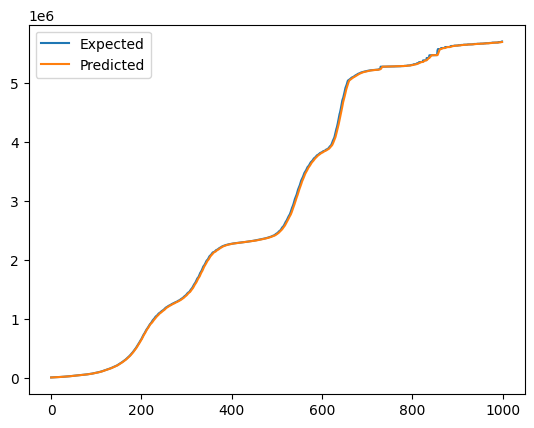

In [56]:

def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

def xgboost_forecast(train, testX):
    train = np.array(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100,
                        reg_alpha=0.000001, 
                        reg_lambda=0.000001)
    model.fit(trainX, trainy)
    yhat = model.predict(np.asarray([testX]))
    return yhat[0], model


def walk_forward_validation(data, n_test):
    predictions = []
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
 
    for i in range(len(test)):
        testX, testy = test[i, :-1], test[i, -1]
        yhat, model = xgboost_forecast(history, testX)
        predictions.append(yhat)
        history.append(test[i])

        print('> Expected=%.1f, Predicted=%.1f' % (testy, yhat))
        
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions, model

values = data['confirmed'].values.reshape(-1, 1) 
data_supervised = series_to_supervised(values, n_in=15, n_out=1)
mae, y, yhat, model = walk_forward_validation(data_supervised, 1000)
print('MAE: %.3f' % mae)

plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [57]:
# scores = cross_val_score(model, X_train, y_train, cv=5)
# print("Mean cross-validation score: %.2f" % scores.mean())

# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

In [73]:
import numpy as np

values = data['confirmed'].values.reshape(-1, 1)  
data_supervised = series_to_supervised(values, n_in=6, n_out=5)


model = XGBRegressor(objective='reg:squarederror', n_estimators=100, reg_alpha=0.00001, 
                        reg_lambda=0.00001)
model.fit(data_supervised[:, :-1], data_supervised[:, -1])


last_values = values[-10:]
row = last_values.flatten()



yhat = model.predict(np.asarray([row[-10:]])) 
row = np.append(row, yhat) 
print('Input: %s, Predicted: %.3f' % (row, yhat))

Input: [5701602. 5701743. 5701855. 5701959. 5711818. 5711929. 5705135.], Predicted: 5705135.000


C:\Users\afedy\AppData\Local\Temp\ipykernel_24656\3964781464.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Input: %s, Predicted: %.3f' % (row, yhat))


: 

In [63]:

values = data['confirmed'].values.reshape(-1, 1) 
new_row = np.array([[yhat]]).reshape(-1, 1)
values= np.concatenate((values, new_row), axis=0)
data_supervised = series_to_supervised(values, n_in=6, n_out=5)


model = XGBRegressor(objective='reg:squarederror', n_estimators=5, reg_alpha=0.00001, 
                        reg_lambda=0.00001)
model.fit(data_supervised[:, :-1], data_supervised[:, -1])


last_values = values[-10:]
row = last_values.flatten()



yhat = model.predict(np.asarray([row[-10:]])) 
row = np.append(row, yhat) 
print('Input: %s, Predicted: %.3f' % (row, yhat))

Input: [5701249.  5701333.  5701474.  5701602.  5701743.  5701855.  5701959.
 5711818.  5711929.  5705134.  5226900.5], Predicted: 5226900.500


C:\Users\afedy\AppData\Local\Temp\ipykernel_24656\1232748861.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Input: %s, Predicted: %.3f' % (row, yhat))
